# Price Prediction - Stage C

## Set Up Notebbok

In [1]:
%pip install pandas matplotlib seaborn sklearn torch 
%pip install "numpy<2" 

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

c:\Users\Ilai\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Ilai\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Load the dataset
file_path = "./data/booking/processed_booking.csv"
df = pd.read_csv(file_path)
df = df.dropna(subset=['review_score'])

## Data Collection and Processing

We prepare features for modeling, including:
- remove missing values in critical features
- Normalization
- One-hot encoding
- Creating new features

**Categorical Features**
- Converting review scores to integer type
- Converting boolean features (is_apartment, breakfast_included) to binary (0/1)
- Handling missing location scores by filling with mean review scores

**Temporal Features**
- Converting snapshot dates to datetime format
- Calculating check-in dates based on time_to_travel
- Extracting day of month for check-in dates


In [4]:
df['review_score'] = df['review_score'].astype(int)
df['location_score'] = (df['location_score']).fillna(df['location_score'].mean()).astype(int)
df['is_apartment'] = (df['is_apartment']).fillna(False).astype(int)
df['breakfast_included'] = (df['breakfast_included']).fillna(False).astype(int)

In [5]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month

In [6]:
df['is_weekend'] = df['checkin_date'].dt.weekday.apply(lambda x: 1 if x in [1,6,7] else 0) 
df['days_to_end_of_month'] = df['checkin_day'].apply(lambda x: 30 - x)  # Days left to the end of the month
display(df.head())

,Unnamed: 0,name,original_price,discounted_price,discount,review_score,review_title,number_of_reviews,star_rating,is_apartment,...,neighborhood_SoHo,neighborhood_Tribeca,neighborhood_Union Square,neighborhood_Upper East Side,neighborhood_Upper West Side,neighborhood_Washington Heights,checkin_date,checkin_day,is_weekend,days_to_end_of_month
0,0,Iroquois New York Times Square,292,218,0,8,Very good,2625.0,5.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
1,1,Four Points by Sheraton New York Downtown,130,111,0,7,Good,1987.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
2,2,"The Mayfair Hotel Times Square, Ascend Hotel C...",141,141,0,8,Fabulous,1895.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
3,3,The Washington by LuxUrban,160,160,0,7,Good,9442.0,4.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
4,4,Hampton Inn by Hilton New York Times Square,152,152,0,7,Good,2432.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27


In [7]:
df['room_type_hash'] = df['room_type'].map(lambda x: hash(x) % 1000)
df['name_hash'] = df['name'].map(lambda x: hash(x) % 1000)

In [8]:
# Define Features and Target
X = df[['time_to_travel', 'length_of_stay','review_score', 'location_score','is_apartment','breakfast_included', 'days_to_end_of_month', 'is_weekend','room_type_hash','name_hash']]  # Features
y = df['discounted_price_per_night']  # Target Variable

In [9]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 🤖 Model Training & Evaluation

We train and evaluate multiple regression models:
- **Linear Regression**
- **Decision Tree Regressor**
- **Gaussian Process Regressor**
- **Neural Networks (Deep Learning)**

We'll assess them using RMSE, MAE, and R².

### Regression Algorithms

- **Linear Regression** – Basic linear model; no hyperparameters, assumes linear relationships.  
- **Decision Tree (max_depth=5,10)** – Splits data into rules; **higher depth** increases complexity but risks overfitting.  
- **Gaussian Process (RBF, Matern)** – Probabilistic model; **kernel type** controls smoothness of predictions.  
- **Random Forest (n_estimators=100, max_depth=5,10)** – Ensemble of trees; **more trees** improve stability, **higher depth** allows deeper splits.  
- **Gradient Boosting (learning_rate=0.1,0.05)** – Boosts weak models; **lower learning rate** slows learning but improves generalization.  
- **SVR (kernel=rbf, linear)** – Supports vector regression; **RBF kernel** captures non-linearity, **linear kernel** assumes a linear trend.  

In [ ]:
# Train Multiple Regression Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree depth 5': DecisionTreeRegressor(max_depth=5),
    'Decision Tree depth 10': DecisionTreeRegressor(max_depth=10),
    'Gaussian Process (RBF)': GaussianProcessRegressor(kernel=RBF(1.0)),
    'Gaussian Process (Matern)': GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=1.5)),
    'Random Forest depth 5': RandomForestRegressor(n_estimators=100, max_depth=5),
    'Random Forest depth 10': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting learning_rate 0.1': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'Gradient Boosting learning_rate 0.05': GradientBoostingRegressor(n_estimators=100, learning_rate=0.05),
    'SVR (kernel=rbf)': SVR(kernel='rbf'),
    'SVR (kernel=linear)': SVR(kernel='linear')
}

In [ ]:
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler()
}
normalization_results = {}
for scaler_name, scaler in scalers.items():
    print(f"Using {scaler_name}")

    X_train_scaled_normalize_diff = scaler.fit_transform(X_train)
    X_test_scaled_normalize_diff = scaler.transform(X_test)

    results_normalize_diff = {}
    for name, model_copy in models.items():
        print(f"Training {name} with {scaler_name}")
        model_copy.fit(X_train_scaled_normalize_diff, y_train)
        y_pred = model_copy.predict(X_test_scaled_normalize_diff)

        results_normalize_diff[name] = {
            "R2": r2_score(y_test, y_pred),
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
        }

    normalization_results[scaler_name] = results_normalize_diff
    
df_results_by_normalize = pd.DataFrame({
    (scaler, model): metrics for scaler, models in normalization_results.items() for model, metrics in models.items()
}).T


display(df_results_by_normalize)

In [12]:
#Train and Evaluate Models
results = {}
for name, model_copy in models.items():
     print(f'current model: {name}')
     model_copy.fit(X_train_scaled, y_train)
     print(f'done fit: {name}')
     y_pred = model_copy.predict(X_test_scaled)
     results[name] = {
          'R2': r2_score(y_test, y_pred),
          'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
     }
     print(f'logged: {name}')

current model: Linear Regression
done fit: Linear Regression
logged: Linear Regression
current model: Decision Tree depth 5
done fit: Decision Tree depth 5
logged: Decision Tree depth 5
current model: Decision Tree depth 10
done fit: Decision Tree depth 10
logged: Decision Tree depth 10
current model: Random Forest depth 5
done fit: Random Forest depth 5
logged: Random Forest depth 5
current model: Random Forest depth 10
done fit: Random Forest depth 10
logged: Random Forest depth 10
current model: Gradient Boosting learning_rate 0.1
done fit: Gradient Boosting learning_rate 0.1
logged: Gradient Boosting learning_rate 0.1
current model: Gradient Boosting learning_rate 0.05
done fit: Gradient Boosting learning_rate 0.05
logged: Gradient Boosting learning_rate 0.05
current model: SVR (kernel=rbf)
done fit: SVR (kernel=rbf)
logged: SVR (kernel=rbf)
current model: SVR (kernel=linear)
done fit: SVR (kernel=linear)
logged: SVR (kernel=linear)


In [13]:
# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
display(results_df)

,R2,MAE,MSE,RMSE
Linear Regression,0.199877,51.862714,4292.835369,65.519733
Decision Tree depth 5,0.320976,46.871693,3643.115445,60.358226
Decision Tree depth 10,0.597300,34.275777,2160.575241,46.481988
Random Forest depth 5,0.362951,45.434200,3417.908155,58.462878
Random Forest depth 10,0.692786,30.084370,1648.273219,40.598931
Gradient Boosting learning_rate 0.1,0.581607,36.457211,2244.772523,47.379030
Gradient Boosting learning_rate 0.05,0.473029,41.531114,2827.313566,53.172489
SVR (kernel=rbf),0.249943,48.400990,4024.222061,63.436756
SVR (kernel=linear),0.175738,50.760072,4422.343947,66.500706


## 🔍 Differences Between Normalization Methods and Practical Implications

###  Observed Differences
1. **Tree-based models (Decision Tree, Random Forest, Gradient Boosting)**  
   - Show minimal sensitivity to different normalization techniques.  
   - Their structure inherently handles varying feature scales, so normalization has little impact.  

2. **Support Vector Regression (SVR)**
   - Highly affected by normalization methods.  
   - Models trained with different scalers produced significantly different \( R^2 \) scores, indicating that SVR relies heavily on feature scaling.  

3. **Linear Regression**
   - Results remained unchanged across all normalization methods.  
   - This suggests that normalization has little effect unless feature scales vary dramatically.  

###  Practical Implications
- **For models that are scale-sensitive (e.g., SVR, neural networks), normalization is crucial** and should be carefully selected based on data distribution.  
- **For models that are less scale-dependent (e.g., decision trees, ensemble methods), normalization is less critical** but may still help with numerical stability.   

BEST MODEL IS: Random Forest depth 10


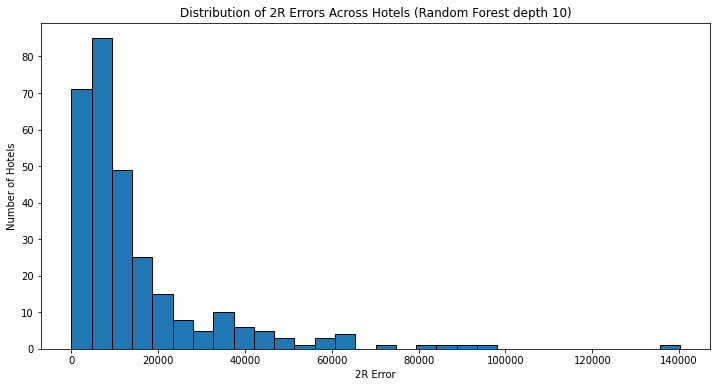

In [15]:
# Plot Residuals for Best Model (Based on R² Score)
best_model_name = results_df['R2'].idxmax()

print(f'BEST MODEL IS: {best_model_name}')
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

df_errors = pd.DataFrame({
    'name_hash': X_test['name_hash'], 
    'y_true': y_test,
    'y_pred': y_pred_best
})
df_errors['error_2R'] = 2 * (df_errors['y_pred'] - df_errors['y_true'])**2

hotel_errors = df_errors.groupby('name_hash')['error_2R'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.hist(hotel_errors['error_2R'], bins=30, edgecolor='black')
plt.xlabel('2R Error')
plt.ylabel('Number of Hotels')
plt.title(f'Distribution of 2R Errors Across Hotels ({best_model_name})')
plt.show()

- **Most hotels have low errors**, clustered near zero.  
- **A few hotels exhibit significantly high errors**, indicating potential outliers or systematic prediction issues.  

### Neural Networks

In [16]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Neural Network Model 1
class NeuralNet1(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Neural Network Model 2 with Embedding
class NeuralNet2(nn.Module):
    def __init__(self, input_dim, embedding_dim=8):
        super(NeuralNet2, self).__init__()
        
        # Embedding layer using a Linear transformation
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.batch_norm1 = nn.BatchNorm1d(embedding_dim)
        
        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.batch_norm1(x)
        x = F.leaky_relu(x)  # Corrected function call

        x = self.fc1(x)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batch_norm3(x)
        x = F.leaky_relu(x)

        x = self.fc3(x)
        return x

def train_model(model, train_loader, test_loader, epochs=50):
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(test_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train NeuralNet1
model1 = NeuralNet1(X_train_scaled.shape[1])
train_model(model1, train_loader, test_loader)

Epoch 1/50, Validation Loss: 52.1771
Epoch 2/50, Validation Loss: 51.1378
Epoch 3/50, Validation Loss: 50.4462
Epoch 4/50, Validation Loss: 49.9626
Epoch 5/50, Validation Loss: 49.4876
Epoch 6/50, Validation Loss: 49.0167
Epoch 7/50, Validation Loss: 48.5517
Epoch 8/50, Validation Loss: 48.1420
Epoch 9/50, Validation Loss: 47.6942
Epoch 10/50, Validation Loss: 47.2974
Epoch 11/50, Validation Loss: 46.9408
Epoch 12/50, Validation Loss: 46.6652
Epoch 13/50, Validation Loss: 46.3824
Epoch 14/50, Validation Loss: 46.1819
Epoch 15/50, Validation Loss: 45.9463
Epoch 16/50, Validation Loss: 45.7491
Epoch 17/50, Validation Loss: 45.5903
Epoch 18/50, Validation Loss: 45.3357
Epoch 19/50, Validation Loss: 45.1595
Epoch 20/50, Validation Loss: 45.0308
Epoch 21/50, Validation Loss: 44.8281
Epoch 22/50, Validation Loss: 44.7035
Epoch 23/50, Validation Loss: 44.6958
Epoch 24/50, Validation Loss: 44.3778
Epoch 25/50, Validation Loss: 44.2457
Epoch 26/50, Validation Loss: 44.1401
Epoch 27/50, Validati

In [17]:
# Train NeuralNet2
model2 = NeuralNet2(X_train_scaled.shape[1])
train_model(model2, train_loader, test_loader)

Epoch 1/50, Validation Loss: 202.6903
Epoch 2/50, Validation Loss: 132.1723
Epoch 3/50, Validation Loss: 62.1197
Epoch 4/50, Validation Loss: 50.9159
Epoch 5/50, Validation Loss: 50.3509
Epoch 6/50, Validation Loss: 50.5388
Epoch 7/50, Validation Loss: 50.1176
Epoch 8/50, Validation Loss: 49.8524
Epoch 9/50, Validation Loss: 49.6824
Epoch 10/50, Validation Loss: 49.5591
Epoch 11/50, Validation Loss: 49.3424
Epoch 12/50, Validation Loss: 49.2223
Epoch 13/50, Validation Loss: 49.3483
Epoch 14/50, Validation Loss: 49.0749
Epoch 15/50, Validation Loss: 48.7440
Epoch 16/50, Validation Loss: 48.9260
Epoch 17/50, Validation Loss: 48.5010
Epoch 18/50, Validation Loss: 48.4285
Epoch 19/50, Validation Loss: 48.2792
Epoch 20/50, Validation Loss: 48.5390
Epoch 21/50, Validation Loss: 48.1237
Epoch 22/50, Validation Loss: 48.1960
Epoch 23/50, Validation Loss: 48.0690
Epoch 24/50, Validation Loss: 47.7023
Epoch 25/50, Validation Loss: 47.5731
Epoch 26/50, Validation Loss: 47.2859
Epoch 27/50, Valida

In [18]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
    
    # Scatter plot: Predictions vs Actual
    plt.figure()
    plt.scatter(y_test.numpy(), y_pred, alpha=0.5, color='blue')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')  # Identity line
    plt.show()

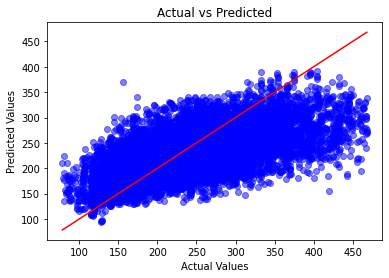

In [19]:
evaluate_model(model1, X_test_tensor, y_test_tensor)

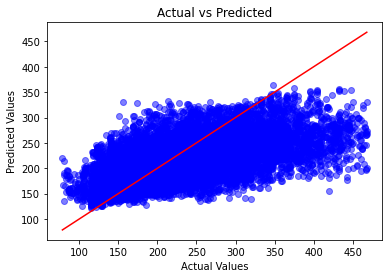

In [20]:
evaluate_model(model2, X_test_tensor, y_test_tensor)

### Rank Feature Imprtance

In [21]:
def display_feature_importance(model_name):
    model_copy = models[model_name]
    importance = model_copy.feature_importances_
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

In [22]:
def display_permutation_importance(model_name):
    model_copy = models[model_name]
    result = permutation_importance(model_copy, X_test_scaled, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean

    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

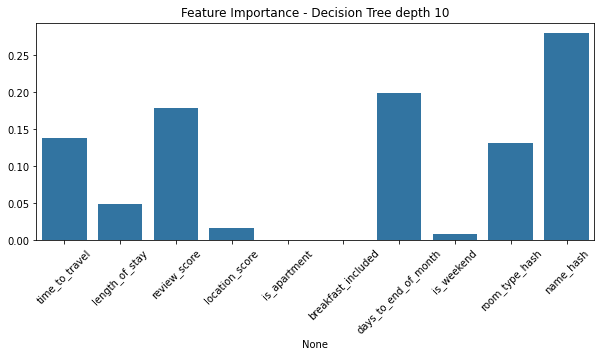

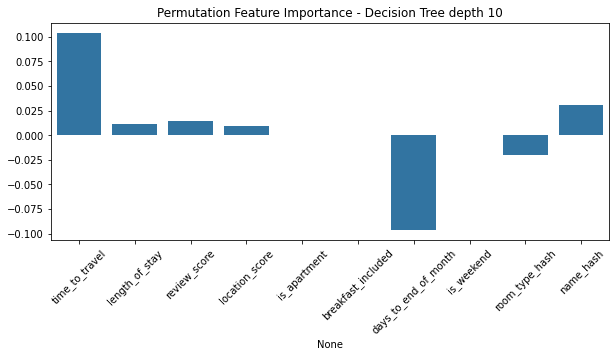

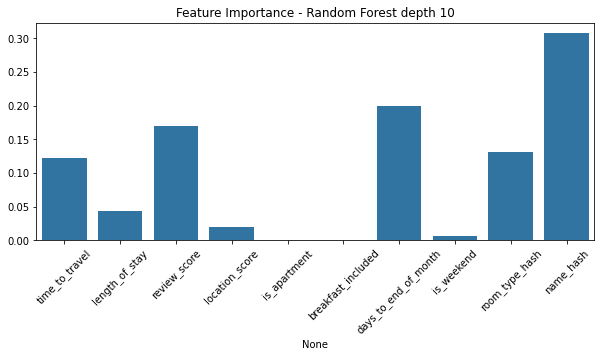

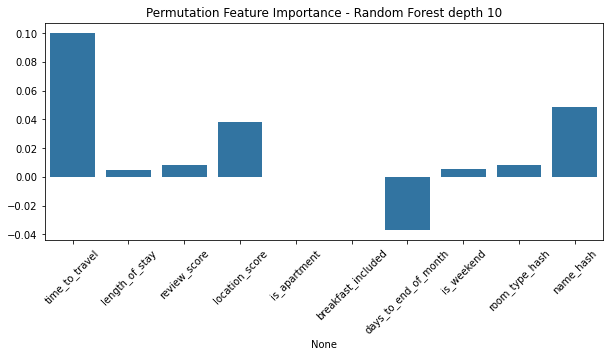

In [23]:
models_to_visualize_feature_impotrence = ['Decision Tree depth 10','Random Forest depth 10']
display_feature_importance(models_to_visualize_feature_impotrence[0])
display_permutation_importance(models_to_visualize_feature_impotrence[0])
display_feature_importance(models_to_visualize_feature_impotrence[1])
display_permutation_importance(models_to_visualize_feature_impotrence[1])

### Residual Plot


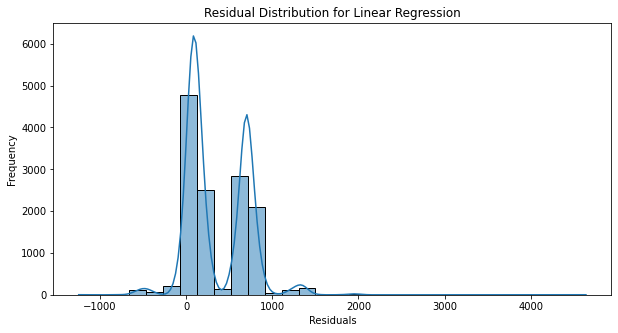

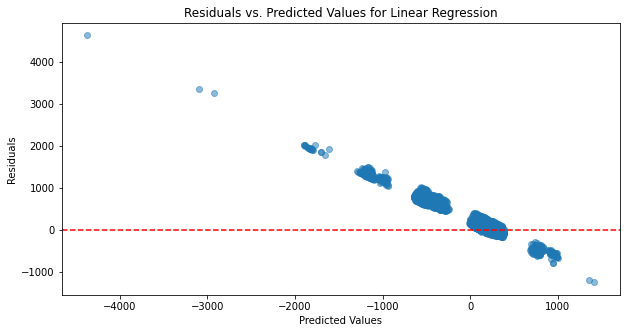

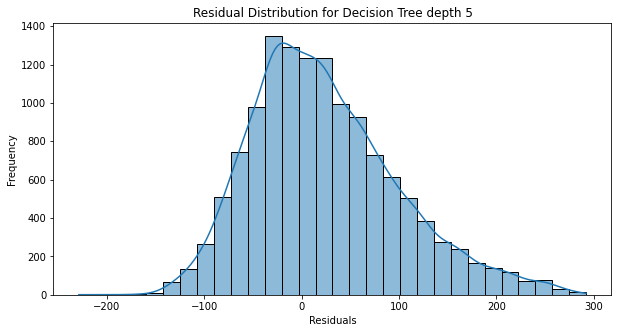

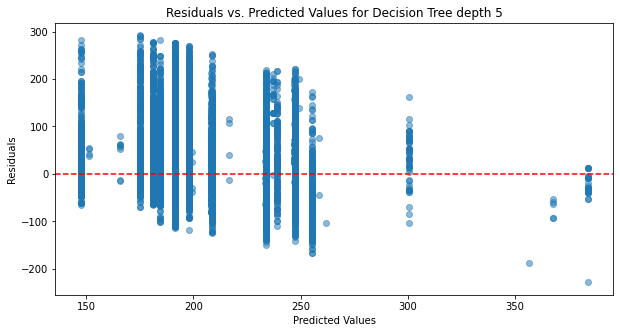

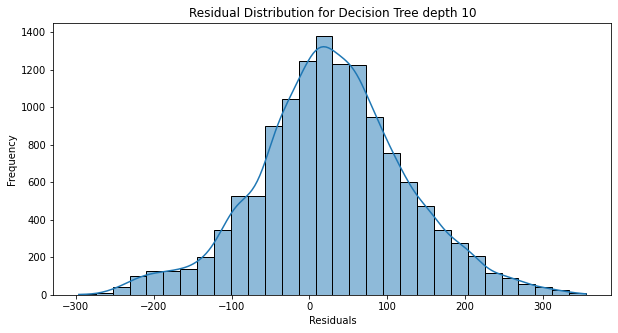

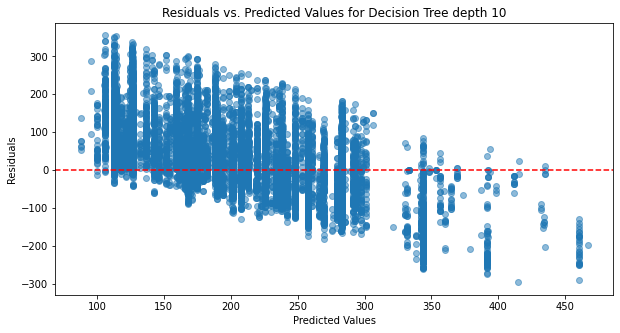

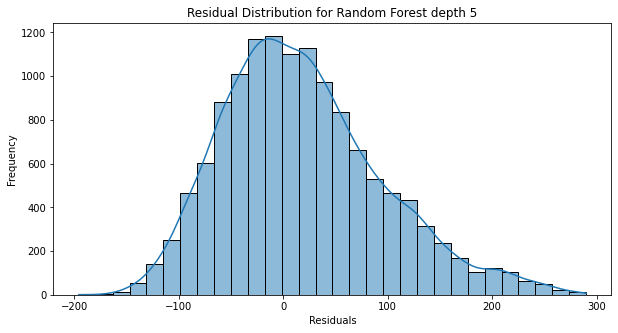

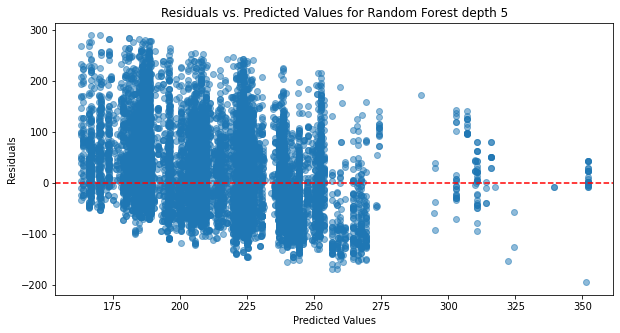

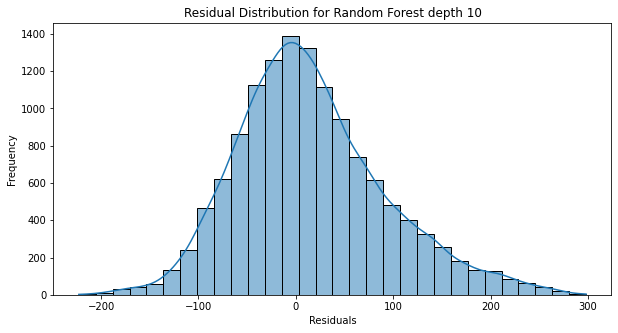

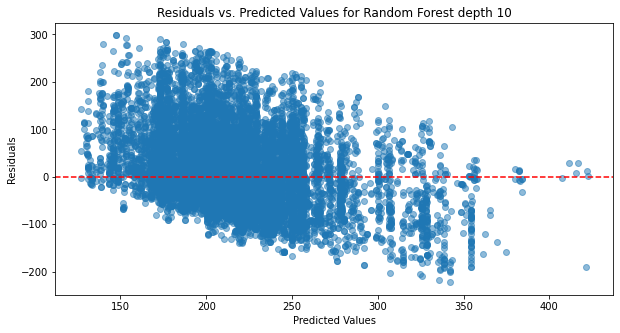

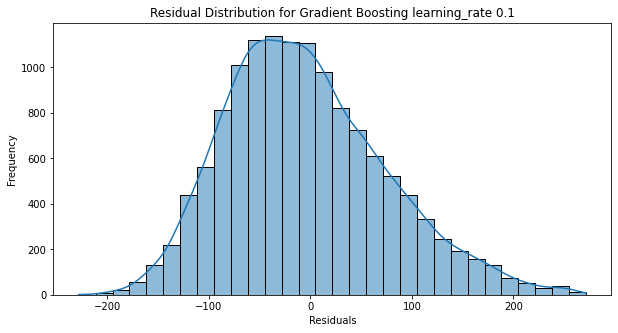

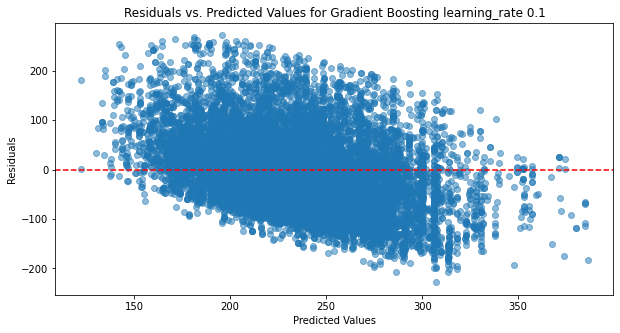

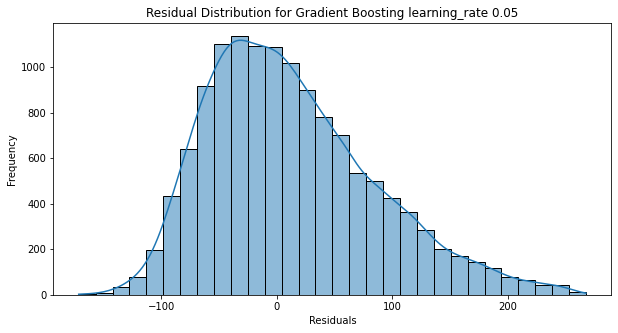

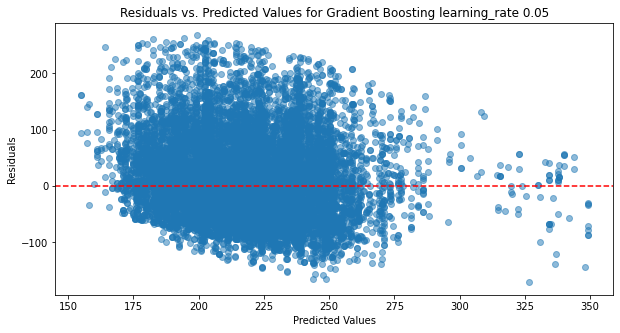

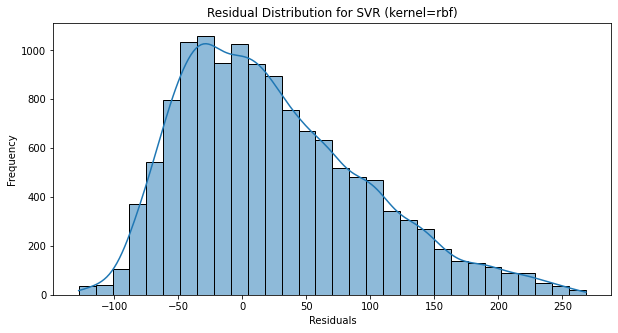

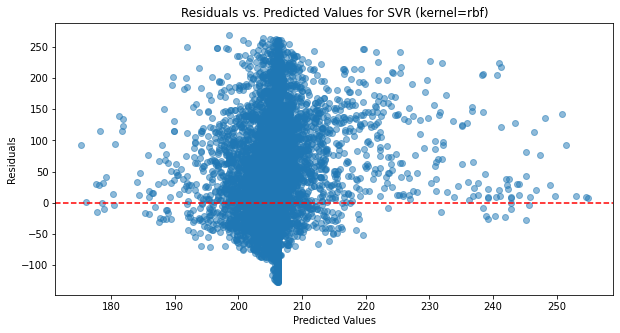

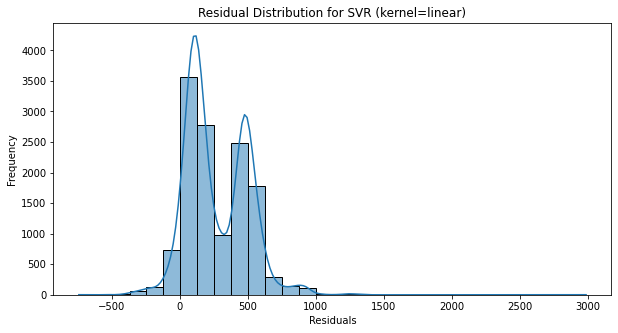

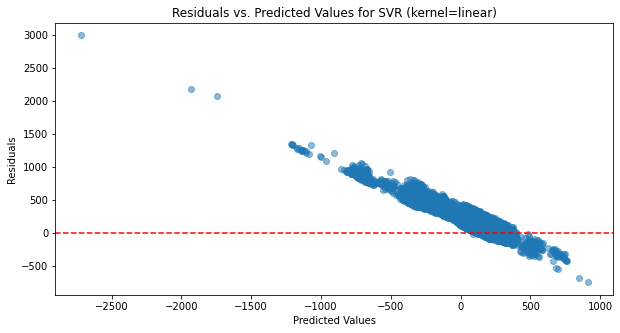

In [24]:
for name, model_copy in models.items():
    y_pred = model_copy.predict(X_test_scaled)
    residuals = y_test - y_pred
    
    # Residual Distribution Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f'Residual Distribution for {name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Scatter Plot of Residuals vs Predicted Values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at zero
    plt.title(f'Residuals vs. Predicted Values for {name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

C:\Users\Ilai\AppData\Local\Temp/ipykernel_30444/1404117669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


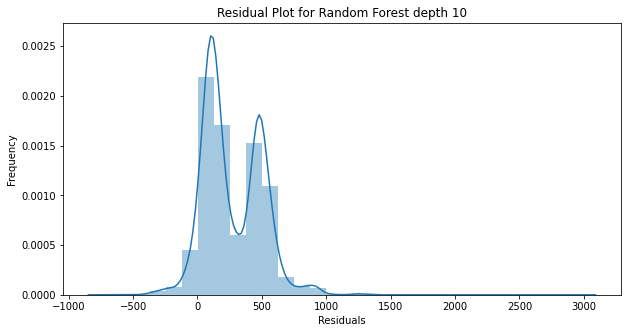

In [25]:
plt.figure(figsize=(10, 5))
sns.distplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



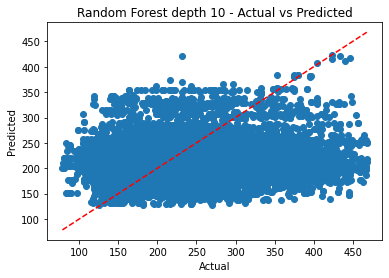

In [26]:
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

plt.scatter(y_test, y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'{best_model_name} - Actual vs Predicted')
plt.show()

## Best Algorith TTT <= 25

In [27]:
X_train_25, X_test_25 = X[X['time_to_travel'] <= 25], X[X['time_to_travel'] > 25]
y_train_25, y_test_25 = y[X['time_to_travel'] <= 25], y[X['time_to_travel'] > 25]

# Re-train the best model and test
best_model.fit(X_train_25, y_train_25)
y_pred_25 = best_model.predict(X_test_25)

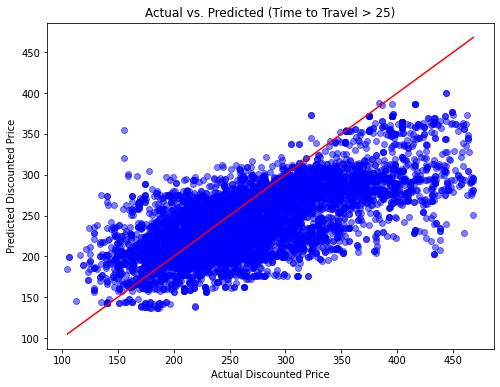

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_25, y_pred_25, alpha=0.5, color='blue')
plt.plot([y_test_25.min(), y_test_25.max()], [y_test_25.min(), y_test_25.max()], 'r')  # Identity line
plt.xlabel('Actual Discounted Price')
plt.ylabel('Predicted Discounted Price')
plt.title('Actual vs. Predicted (Time to Travel > 25)')
plt.show()

In [29]:
results = {
          'R2': r2_score(y_test_25, y_pred_25),
          'MAE': mean_absolute_error(y_test_25, y_pred_25),
          'MSE': mean_squared_error(y_test_25, y_pred_25),
          'RMSE': np.sqrt(mean_squared_error(y_test_25, y_pred_25))
     }
results

{'R2': 0.3291890220560192,
 'MAE': 43.927769468497715,
 'MSE': 3278.580947368358,
 'RMSE': 57.258894045976454}